In [2]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import math as m
import queue

In [3]:
def create_dataset(datapath):
    #读取dat文件作为聚类数据的数据集
    data = np.loadtxt(datapath)
    X = data[:, 0:]
    #转化X为np.array
    X = np.array(X)
    return X

datapath = './data/clusterData2.8k.dat'
X_train = create_dataset(datapath)

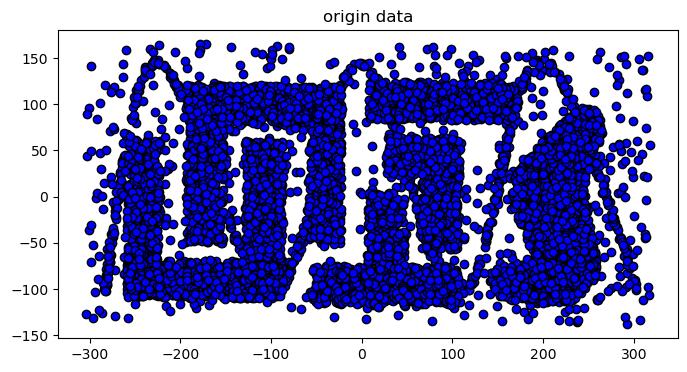

In [4]:
#可视化数据集
def visualize_data(X):
    #对数据进行降维处理
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(8,4))
    plt.title('origin data')
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', marker='o', label='datapoints',edgecolors='black')
    plt.show()

visualize_data(X_train)


In [5]:
def visualize(X, y, y_pred, title=None, type='pca'):
    # 可视化,pca降维或者tsne
    if type == 'pca':
        pca = PCA(n_components=2)
        X_dim_reduction = pca.fit_transform(X)

    elif type == 'tsne':
        t_sne = TSNE(n_components=2)
        X_dim_reduction = t_sne.fit_transform(X)
    else:
        X_dim_reduction = X
    # print(X_dim_reduction.shape)
    plt.figure(figsize=(16, 6))

    def get_color(y):
        color_dict = {-1: 'white', 0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'magenta', 
                      5: 'blue', 6: 'cyan', 7: 'brown', 8: 'purple', 9: 'aquamarine'}
        color = []
        for i in range(y.shape[0]):
            color.append(color_dict.get(y[i].item(), 'olive'))
        return color
    plt.suptitle(title, fontweight=16)
    plt.subplot(121)
    plt.title('origin data')
    #使用降维后的两个维度进行绘图
    plt.scatter(X_dim_reduction[:, 0], X_dim_reduction[:, 1], c=get_color(y), edgecolors='black')
    plt.subplot(122)
    plt.title('cluster result')
    plt.scatter(X_dim_reduction[:, 0], X_dim_reduction[:, 1], c=get_color(y_pred), edgecolors='black')
    plt.show()

In [6]:
class DBSCAN:
    def __init__(self, radius, minPts):
        self.data = None
        self.radius = radius
        self.minPts = minPts
        self.NOISE = 0
        self.UNASSIGNED = -1
        self.clusterId = 1
        self.clusterRes = {}
        
    def dist(self,a, b):
        return m.sqrt(np.power(a-b, 2).sum())  
    
    #获取核心点的邻域内的所有点
    def neighbor_points(self,coreId):
        points = []
        for i in range(len(self.data)):
            if self.dist(self.data[i, 0: 2], self.data[coreId, 0: 2]) < self.radius:
                points.append(i)
        return np.asarray(points)
    
    
    def to_cluster(self,sampleId):
        points = self.neighbor_points(sampleId)
        points = points.tolist()
        q = queue.Queue()
        # 通过密度判断是核心点还是噪声/边界点
        if len(points) < self.minPts:
            self.clusterRes[sampleId] = self.NOISE
            return False
        # 若是核心点，将其加入到一个新的类中
        else:
            self.clusterRes[sampleId] = self.clusterId
        # 将核心点邻域内的所有点加入到一个新的类中，并加入遍历队列
        for point in points:
            if self.clusterRes[point] == self.UNASSIGNED:
                    q.put(point)
                    self.clusterRes[point] = self.clusterId

        # 对核心点邻域内的点sampleId进行遍历
        while not q.empty():
            sampleId = q.get()
            neighborRes = self.neighbor_points(sampleId)
            #对sampleId邻域内的点进行遍历
            if len(neighborRes) >= self.minPts:                    
                for i in range(len(neighborRes)):
                    resultPoint = neighborRes[i]
                    # 若该点是核心点，将其邻域内的未分配点加入到新类中,并加入遍历队列
                    if self.clusterRes[resultPoint] == self.UNASSIGNED:
                        q.put(resultPoint)
                        self.clusterRes[resultPoint] = self.clusterId
                    # 若该点是边界点，直接加入到新类中
                    elif self.clusterRes[self.clusterId] == self.NOISE:
                        self.clusterRes[resultPoint] = self.clusterId
        return True
    
    def fit(self,data):
        self.data = data
        nPoints = len(self.data)
        #初始化聚类结果
        self.clusterRes = [self.UNASSIGNED] * nPoints
        #遍历每一个样本点
        for sampleId in range(nPoints):
            if self.clusterRes[sampleId] == self.UNASSIGNED:
                if self.to_cluster(sampleId):
                    self.clusterId = self.clusterId + 1
        return np.asarray(self.clusterRes), self.clusterId


In [7]:
#DBSCAN聚类
raidus = 10
minPts = 18
dbscan = DBSCAN(raidus, minPts)
clusterRes, nClusters = dbscan.fit(X_train)
print('number of clusters:', nClusters)
print('clusterRes:', clusterRes)


number of clusters: 7
clusterRes: [1 2 1 ... 4 4 4]


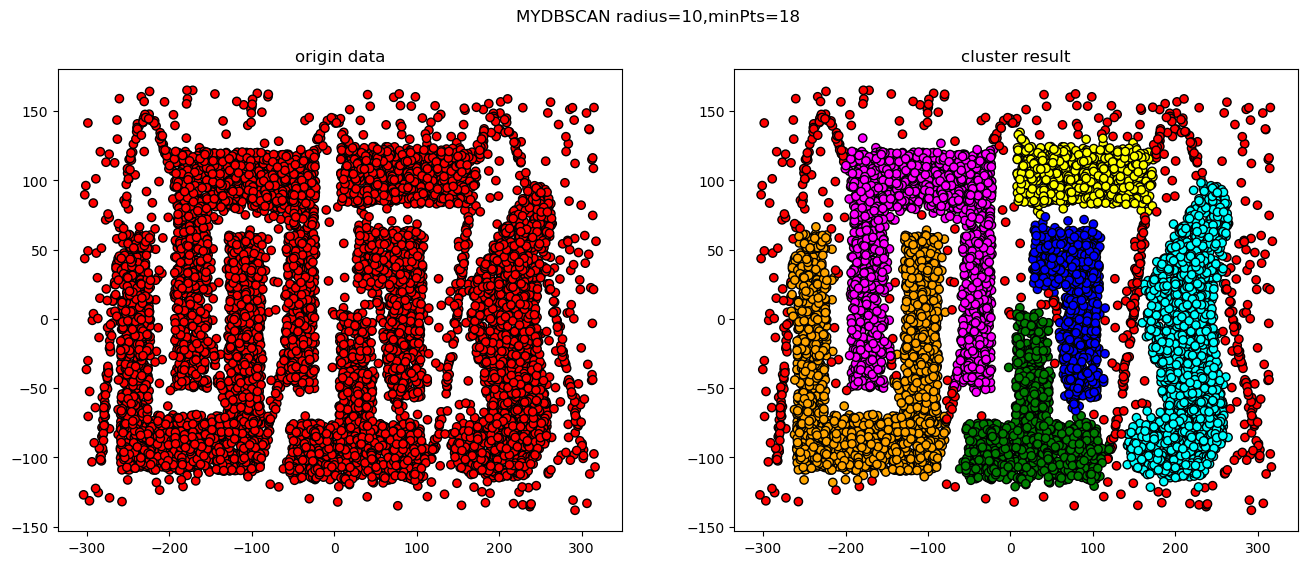

In [10]:
y = np.zeros(X_train.shape[0])
visualize(X_train, y, clusterRes, title=f'MYDBSCAN radius={raidus},minPts={minPts}', type='pca')

number of clusters: 7


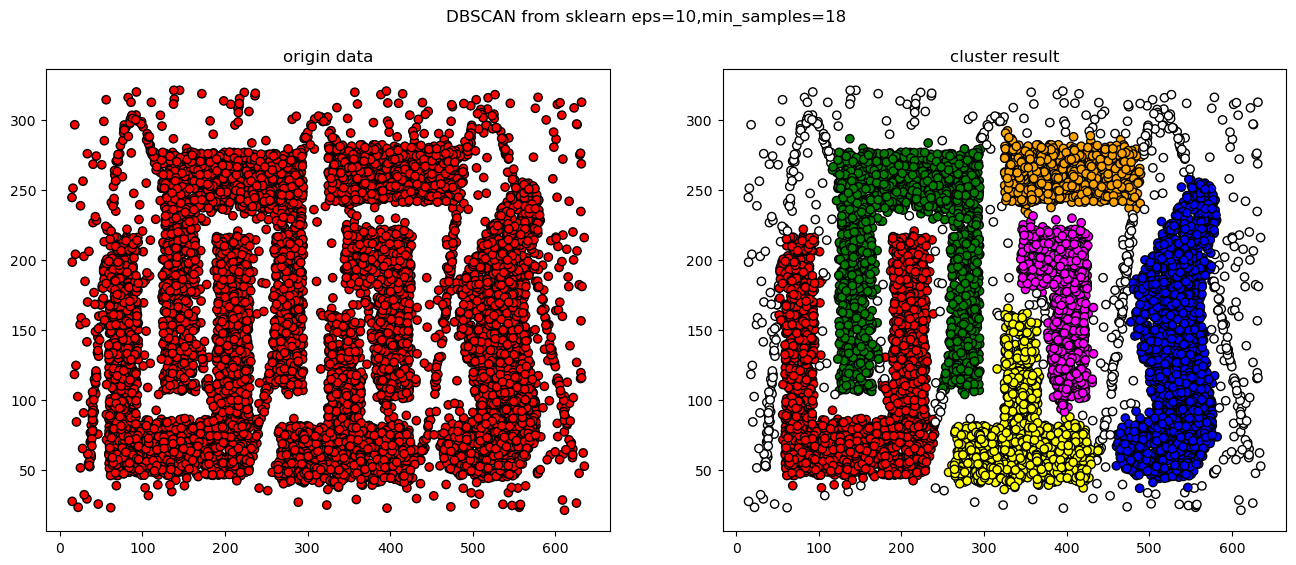

In [11]:
from sklearn.cluster import DBSCAN
eps = 10
min_samples = 18
dbscan = DBSCAN(eps=10, min_samples=18)
dbscan.fit(X_train)
y_pred = dbscan.labels_
print('number of clusters:', len(set(y_pred)))
visualize(X_train, y, y_pred, title=f'DBSCAN from sklearn eps={eps},min_samples={min_samples}', type=None)